Author : El Mahdi CHAYTI

In [1]:
import numpy as np
from numpy.linalg import norm
import seaborn as sns
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
% %matplotlib inline

sns.set()
np.set_printoptions(precision=3)

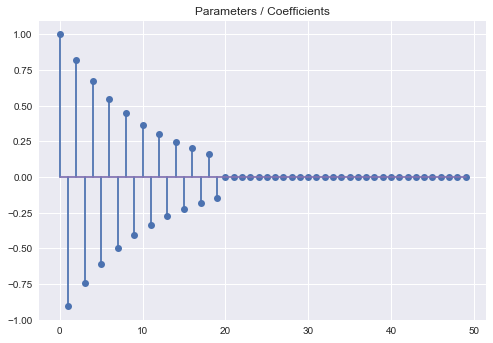

In [3]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

## Fonction pour générer les données

In [4]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    n_features = len(coefs)
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Définitions de fonctions dont on a besoin

Le prox du lasso est donné par la formule suivante :

Pour $x=(x_1, \dots , x_n)$ : $$Prox_{s\Vert \cdot \Vert_1}(x)_i = signe(x_i) (\vert x_i \vert_1 - s)_+ $$ $\forall i \in \{1, \dots, n\} $

Où $(x)_+ = max(x,0)$

In [5]:
def prox_lasso(x, s, step):
    """Proximal operator for the Lasso at x"""    
    return np.sign(x) * np.maximum(np.abs(x) - s * step,0)

def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s*norm(x, ord=1)

In [6]:
def loss_linreg(x):
    """Least-squares loss"""
    return norm(A @ x - b, ord=2)**2/ 2 / n_samples

def grad_linreg(x):
    """Least_squares grad"""
    return A.T @ (A @ x - b) / n_samples

In [7]:
from scipy.optimize import check_grad
np.random.seed(1)
A, b = simu_linreg(coefs=coefs)
x0 = np.random.randn(n_features)
# check the gradient
print(check_grad(loss_linreg, grad_linreg, x0))

6.5616048214274395e-06


In [8]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return norm(A, ord=2)**2 / n_samples

## Algorithmes : PGD (ISTA) et Accelerated PGD (FISTA)

In [10]:
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=1000,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x = prox_g(x - step*grad_f(x), s, step)
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [12]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=1000,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(z-step*grad_f(z), s, step)
        t_new = .5*(1+np.sqrt(1+4*t**2))
        z = x_new + ((t-1)/t_new)*(x_new-x)
        t = t_new
        x = x_new

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [13]:
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2

In [14]:
A, b = simu_linreg(coefs)
x_opt = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso,
              step=1/(lip_linreg(A)), s=s, n_iter=1000, verbose=False)[0]

In [15]:
objective_ista, error_ista = \
    ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, x_true=x_opt,
         step=1 / lip_linreg(A), s=s, n_iter=n_iter, verbose=False)[1:3]
objective_fista, error_fista = \
    fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, x_true=x_opt,
         step=1 / lip_linreg(A), s=s, n_iter=n_iter, verbose=False)[1:3]

objective_fista -= loss_linreg(x_opt) + lasso(x_opt, s)
objective_ista -= loss_linreg(x_opt) + lasso(x_opt, s)

## Comparaison de ISTA et FISTA(la version accélérée de PGD)

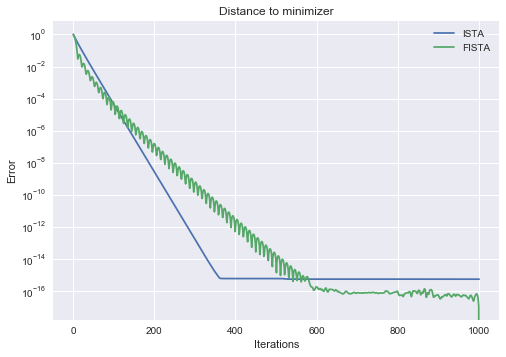

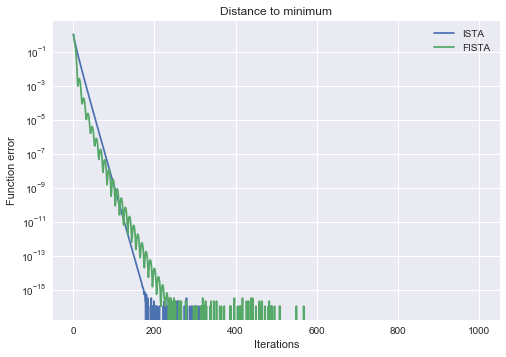

In [17]:
# Distance to minimizer: x_t - x*
iterations = np.arange(n_iter+2)
plt.figure(1)
plt.semilogy(iterations, error_ista, label="ISTA")
plt.semilogy(iterations, error_fista, label="FISTA")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.title("Distance to minimizer")
plt.savefig("Distance_to_minimizer")
# Distance to minimum: f(x_t) - f(x*)
plt.figure(2)
plt.semilogy(iterations, objective_ista, label="ISTA")
plt.semilogy(iterations, objective_fista, label="FISTA")
plt.xlabel("Iterations")
plt.ylabel("Function error")
plt.legend()
plt.title("Distance to minimum")
plt.savefig("Distance_to_minimum")

##  Comparaison du support

Text(0.5, 1.0, 'Coefs (true solution)')

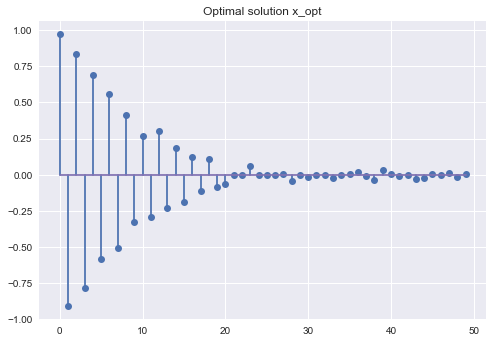

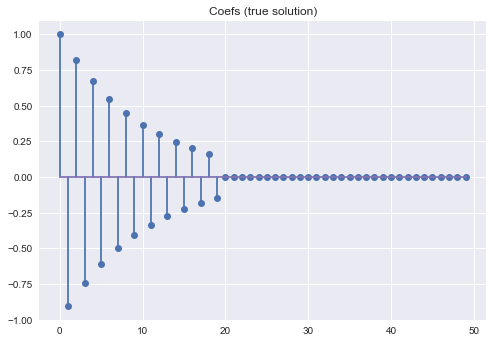

In [18]:
plt.figure(1)
plt.stem(x_opt)
plt.title("Optimal solution x_opt")
plt.savefig("solution_of_PGD")
plt.figure(2)
plt.stem(coefs)
plt.title("Coefs (true solution)")

## Influence de la constante de regularisation :

In [19]:
def test_performance(penalization_coefs=[1e-2],
                     n_trials=1):
    global A, b
    sum_results_ista = np.zeros(len(penalization_coefs))
    sum_results_fista = np.zeros(len(penalization_coefs))

    for i in range(n_trials):
        errors_ista = list()
        objectives_ista = list()
        errors_fista = list()
        objectives_fista = list()
        results_ista = list()
        results_fista = list()
        a = randn(50)

        A, b = simu_linreg(coefs)
        for s in penalization_coefs:
            x_opt = ista(x0,loss_linreg, grad_linreg,
                         lasso, prox_lasso, x_true=coefs,
                         step=1 / lip_linreg(A), s=s,
                         n_iter=n_iter, verbose=False)[0]

            x_ista, objective_ista, error_ista = \
                ista(x0, loss_linreg, grad_linreg,
                     lasso, prox_lasso, x_true=x_opt,
                     step=1 / lip_linreg(A), s=s,
                     n_iter=n_iter, verbose=False)
            
            x_fista, objective_fista, error_fista = \
                fista(x0, loss_linreg, grad_linreg,
                      lasso, prox_lasso, x_true=x_opt,
                      step=1/lip_linreg(A), s=s,
                      n_iter=n_iter, verbose=False)

            objective_ista -= loss_linreg(x_opt) + lasso(x_opt, s)
            objective_fista -= loss_linreg(x_opt) + lasso(x_opt, s)

            errors_ista.append(error_ista)
            errors_fista.append(error_fista)
            objectives_ista.append(objective_ista)
            objectives_fista.append(objective_fista)
            results_ista.append(norm(x_ista-x_opt))
            results_fista.append(norm(x_fista-x_opt))

        sum_results_ista += results_ista
        sum_results_fista += results_fista
    return (sum_results_ista/n_trials, sum_results_fista/n_trials,
            errors_ista, errors_fista,
            objectives_ista, objectives_fista)

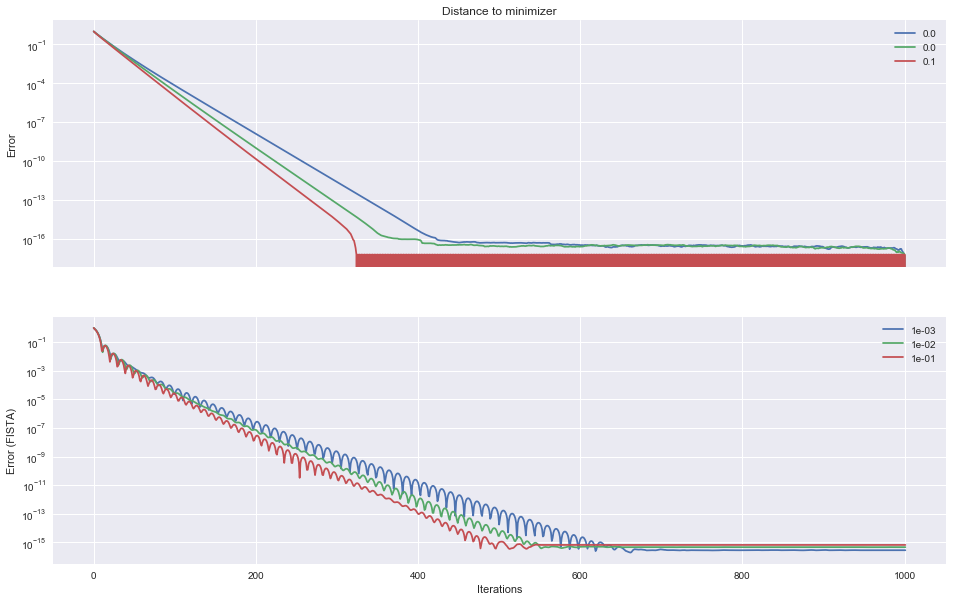

In [21]:
np.random.seed(2)
penalization_coefs = np.array([0.001, 0.01, 0.1])
errors_ista, errors_fista =\
    test_performance(penalization_coefs=penalization_coefs, n_trials=1)[2:4]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
for (i, errors) in enumerate(errors_ista):
    ax[0].semilogy(iterations, errors, label=format(penalization_coefs[i], ".1f"))
for (i, errors) in enumerate(errors_fista):
    ax[1].semilogy(iterations, errors, label='{:.0e}'.format(penalization_coefs[i]))
ax[1].set_xlabel("Iterations")
ax[0].set_ylabel("Error")
ax[1].set_ylabel("Error (FISTA)")
ax[0].set_title("Distance to minimizer")
ax[1].legend()
ax[0].legend()
plt.savefig("comparaison_of_multiple_lambda_values")

L'algorithme converge d'autant plus rapidement que la constante de régularisation est grande, la raison est qu'elle est plus facile de minimiser le terme de lasso que de minimiser le terme quadratique

##  Ajout d'une condition d'arret :

On va considérer comme condition d'arret :
$$ \Vert x^{k+1} - x^{k} \Vert_2 \leq rtol = 10^{-10}$$

et on va ajouter une condition sur le nombre d'itérations possibles

In [25]:
def TP1(A, b, s=0.01, n_iter=1000, 
        rtol=1e-10, verbose=True):
    """Proximal gradient descent algorithm
    ------------------------------------------------
    Solves the minimization problem :
    min 0.5 || Ax - b ||_2^2 / n_samples + s ||x||_1
    ------------------------------------------------
    prameters :
    
    A : numpy array (n_samples * n_features)
    b : numpy array (n_samples)
    s : a positif float(Lasso's regularization)
    rtol : minimum tolerance
    n_iter : maximum number of iterations
    verbose : when true prints things 
    ------------------------------------------------
    returns :
    
    x : the optimal solution found
    obj : a numpy array [ f(x_k) for k = 1...till convergence]
    precision : a numpy array [prec_k = norm(x_{k+1} - x_k)]
    
    """
    n_samples, n_features = A.shape
    
    def g(x, s):
        """Value of the Lasso penalization at x"""
        return s*norm(x, ord=1)
    
    def f(x):
        """Least-squares loss"""
        return norm(A @ x - b, ord=2)**2/ 2 / n_samples
    
    def prox_g(x, s, step):
        """Proximal operator for the Lasso at x"""    
        return np.sign(x) * np.maximum(np.abs(x) - s * step,0)

    def grad_f(x):
        """Least_squares grad"""
        return A.T @ (A @ x - b) / n_samples
    
    def lip_(A):
        """Lipschitz constant for linear squares loss"""    
        return norm(A, ord=2)**2 / n_samples

    step = 1 / lip_(A)
    
    x = np.zeros(n_features)
    x_new = x.copy()

    # estimation error history
    precision = []
    # objective history
    objectives = []
    # Current estimation error
#     errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "prec"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(x - step * grad_f(x), s, step)
        
        prec = norm(x_new - x) / max(1, norm(x_new))
        x = x_new
        obj = f(x) + g(x, s)
    
        precision.append(prec)
        objectives.append(obj)
        
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % prec).rjust(8)]))
        if prec <= rtol:
            print("converged")
            break
            
        if k == n_iter :
            print("algorithm did not converge, increase N_iter ")
            
    return x, np.array(objectives), np.array(precision)

In [29]:
coefs = np.random.choice([0, 4, 40], size=n_features, p= [.8, .1, .1])
A, b = simu_linreg(coefs)
x_opt = TP1(A, b, s=s, n_iter=1000, verbose=True)[0]

Lauching PGD solver...
   it    |   obj    |   prec  
       0 | 1.21e+03 | 1.00e+00
      10 | 4.32e+01 | 2.32e-02
      20 | 7.57e+00 | 6.85e-03
      30 | 3.34e+00 | 2.50e-03
      40 | 2.72e+00 | 9.76e-04
      50 | 2.62e+00 | 3.88e-04
      60 | 2.61e+00 | 1.38e-04
      70 | 2.61e+00 | 4.94e-05
      80 | 2.61e+00 | 1.88e-05
      90 | 2.61e+00 | 7.32e-06
     100 | 2.61e+00 | 2.94e-06
     110 | 2.61e+00 | 1.19e-06
     120 | 2.61e+00 | 4.83e-07
     130 | 2.61e+00 | 1.97e-07
     140 | 2.61e+00 | 8.03e-08
     150 | 2.61e+00 | 3.28e-08
     160 | 2.61e+00 | 1.34e-08
     170 | 2.61e+00 | 5.50e-09
     180 | 2.61e+00 | 2.25e-09
     190 | 2.61e+00 | 9.22e-10
     200 | 2.61e+00 | 3.78e-10
     210 | 2.61e+00 | 1.55e-10
converged


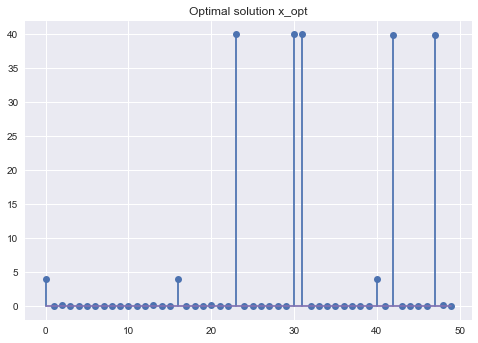

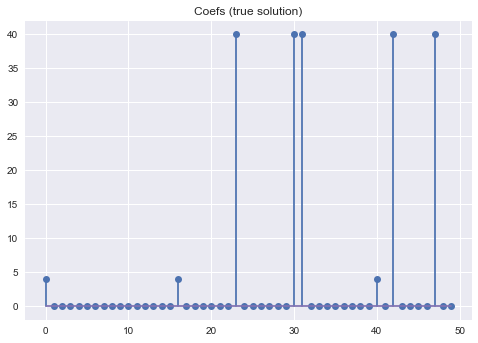

In [31]:
plt.figure(1)
plt.stem(x_opt)
plt.title("Optimal solution x_opt")
plt.savefig("solution_of_PGD2")
plt.figure(2)
plt.stem(coefs)
plt.title("Coefs (true solution)")
plt.savefig("coef2")